### Load the trainer

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.colors import to_rgb
from PIL import Image


def draw_box_on_image(image, box, color=(255, 0, 0)):
    """
    Draws a rectangle on a given PIL image using the provided box coordinates in xywh format.
    :param image: PIL.Image - The image on which to draw the rectangle.
    :param box: tuple - A tuple (x, y, w, h) representing the top-left corner, width, and height of the rectangle.
    :param color: tuple - A tuple (R, G, B) representing the color of the rectangle. Default is red.
    :return: PIL.Image - The image with the rectangle drawn on it.
    """
    # Ensure the image is in RGB mode
    image = image.convert("RGB")
    # Unpack the box coordinates
    x, y, w, h = box
    x, y, w, h = int(x), int(y),int( w),int( h) 
    # Get the pixel data
    pixels = image.load()
    # Draw the top and bottom edges
    for i in range(x, x + w):
        pixels[i, y] = color
        pixels[i, y + h - 1] = color
    # Draw the left and right edges
    for j in range(y, y + h):
        pixels[x, j] = color
        pixels[x + w - 1, j] = color
    return image


def show_img_tensor(img_batch, vis_img_idx=0):
    MEAN_IMG = np.array([0.485, 0.456, 0.406])
    STD_IMG = np.array([0.229, 0.224, 0.225])
    im_tensor = img_batch[vis_img_idx].detach().cpu()
    assert im_tensor.dim() == 3
    im_tensor = im_tensor.numpy().transpose((1, 2, 0))
    im_tensor = (im_tensor * STD_IMG) + MEAN_IMG
    im_tensor = np.clip(im_tensor, 0, 1)
    plt.imshow(im_tensor)


def show_points_with_labels(coords, labels, ax=None, marker_size=200):
    if ax is None:
        ax = plt.gca()
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="*", s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="*", s=marker_size, edgecolor="white", linewidth=1.25)


def plot_bbox(
    img_height,
    img_width,
    box,
    box_format="XYXY",
    relative_coords=True,
    color="r",
    linestyle="solid",
    text=None,
):
    if box_format == "XYXY":
        x, y, x2, y2 = box
        w = x2 - x
        h = y2 - y
    elif box_format == "XYWH":
        x, y, w, h = box
    elif box_format == "CxCyWH":
        cx, cy, w, h = box
        x = cx - w / 2
        y = cy - h / 2
    else:
        raise RuntimeError(f"Invalid box_format {box_format}")

    if relative_coords:
        x *= img_width
        w *= img_width
        y *= img_height
        h *= img_height

    rect = patches.Rectangle(
        (x, y), w, h, linewidth=1.5, edgecolor=color, facecolor="none", linestyle=linestyle,
    )
    plt.gca().add_patch(rect)

    if text is not None:
        facecolor = "w"
        plt.gca().text(
            x, y - 13, text, color=color, weight="bold", fontsize=8,
            bbox={"facecolor": facecolor, "alpha": 0.75, "pad": 2},
        )


def plot_mask(mask, color="r"):
    im_h, im_w = mask.shape
    mask_img = np.zeros((im_h, im_w, 4), dtype=np.float32)
    mask_img[..., :3] = to_rgb(color)
    mask_img[..., 3] = mask * 0.5
    plt.imshow(mask_img)

In [52]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# Build Model

In [53]:

from sam3 import build_sam3_image_model


checkpoint_path = "assets/checkpoints/sam3_v12_rc5.pt"
bpe_path = "assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path=checkpoint_path)


# Load Image into Model

In [54]:

image_path = "assets/images/test_image.jpg"
inference_state = model.init_state(image_path)
model.reset_state(inference_state)

# Adding a point input

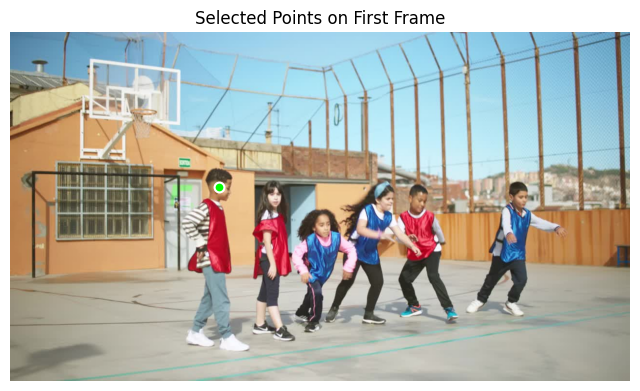

Normalized selected points: [[0.3359375, 0.4444444444444444]]
Normalized point: [[0.3359375  0.44444445]]


In [55]:
# Multiple selected points: list of [x, y] pairs
selected_points = [
	[430, 320],
]

img0 = Image.open(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img0)
xs = [pt[0] for pt in selected_points]
ys = [pt[1] for pt in selected_points]
plt.scatter(xs, ys, color='lime', marker='o', s=50, edgecolor='white', linewidth=1.5)
plt.title("Selected Points on First Frame")
plt.axis('off')
plt.show()

width, height = img0.size

selected_points_normalized = [[x / width, y / height] for x, y in selected_points]
print("Normalized selected points:", selected_points_normalized)


model.reset_state(inference_state)

for idx in range(len(selected_points_normalized)):
    norm_point = np.array(selected_points_normalized[idx:idx+1], dtype=np.float32)
    print("Normalized point:", norm_point)
    out = model.add_prompt(inference_state, points=norm_point, point_labels=np.ones((norm_point.shape[0],)), output_prob_thresh=0.5, instance_prompt=True)




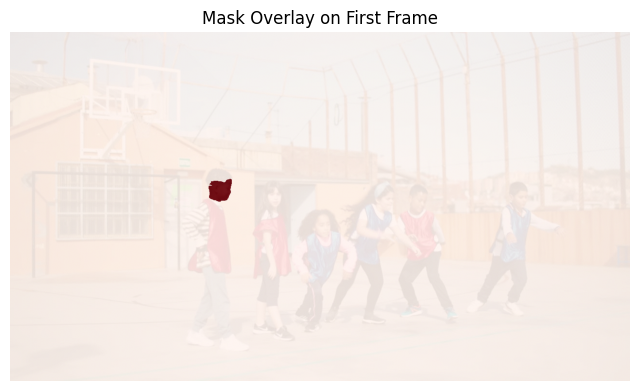

In [56]:
img0 = Image.open(image_path)
binary_mask = out['out_binary_masks'][0]
plt.figure(figsize=(8, 6))
plt.imshow(img0)
plt.imshow(binary_mask, cmap='Reds', alpha=0.9)
plt.axis('off')
plt.title("Mask Overlay on First Frame")
plt.show()

# Refine the output mask using a negative point

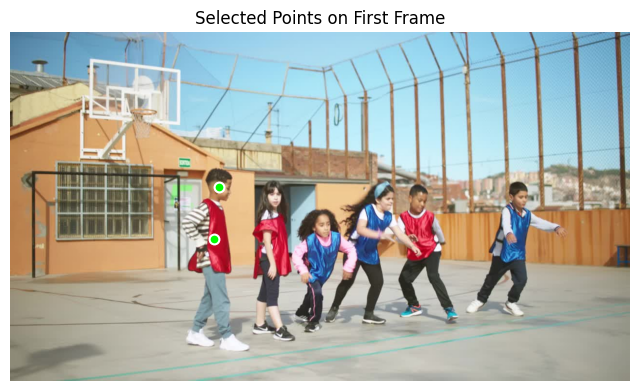

Normalized selected points: [[0.328125, 0.5916666666666667], [0.3359375, 0.4444444444444444]]
Normalized point: [[0.328125   0.59166664]]
Normalized point: [[0.3359375  0.44444445]]


In [57]:
# Multiple selected points: list of [x, y] pairs
selected_points = [
	[420, 426], # Refinement click
	[430, 320], # initial click
]
img0 = Image.open(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img0)
xs = [pt[0] for pt in selected_points]
ys = [pt[1] for pt in selected_points]
plt.scatter(xs, ys, color='lime', marker='o', s=50, edgecolor='white', linewidth=1.5)
plt.title("Selected Points on First Frame")
plt.axis('off')
plt.show()

width, height = img0.size

selected_points_normalized = [[x / width, y / height] for x, y in selected_points]
print("Normalized selected points:", selected_points_normalized)

for idx in range(len(selected_points_normalized)):
    norm_point = np.array(selected_points_normalized[idx:idx+1], dtype=np.float32)
    print("Normalized point:", norm_point)
    out = model.add_prompt(inference_state, frame_idx=0, points=norm_point, point_labels=np.ones((norm_point.shape[0],)), output_prob_thresh=0.5, instance_prompt=True)



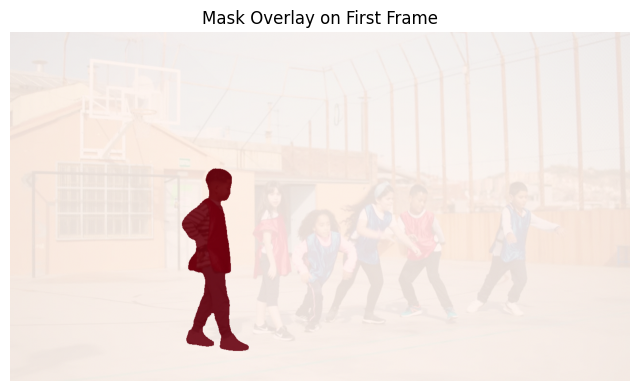

In [58]:
img0 = Image.open(image_path)
binary_mask = out['out_binary_masks'][0]
plt.figure(figsize=(8, 6))
plt.imshow(img0)
plt.imshow(binary_mask, cmap='Reds', alpha=0.9)
plt.axis('off')
plt.title("Mask Overlay on First Frame")
plt.show()

# Visual prompt

Normalized box: [[0.375      0.40277778 0.0859375  0.5       ]]


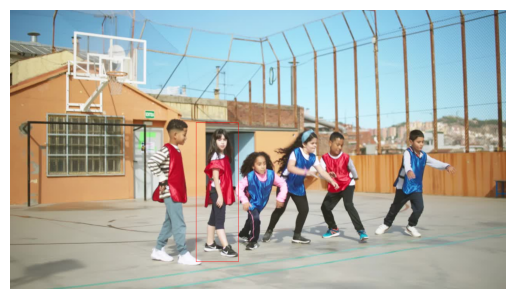

In [59]:
box_input_xywh = np.array([[480.0, 290.0, 110.0 , 360.0]])
model.reset_state(inference_state)
for idx in range(len(box_input_xywh)):
    norm_box_xywh = box_input_xywh / np.array([width, height, width, height], dtype=np.float32).reshape(1,-1)
    print("Normalized box:", norm_box_xywh)
    out = model.add_prompt(inference_state, frame_idx=0, boxes_xywh=norm_box_xywh, box_labels=np.ones((norm_box_xywh.shape[0],)), output_prob_thresh=0.5,)# instance_prompt=True)


img0 = Image.open(image_path)
image_with_box = draw_box_on_image(img0, box_input_xywh[0].tolist() )
plt.imshow(image_with_box)
plt.axis('off')  # Hide the axis
plt.show()

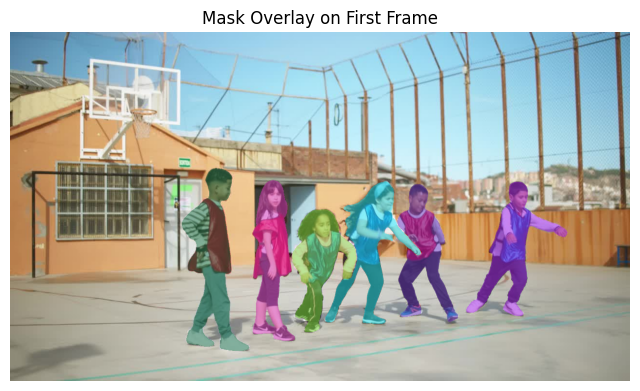

In [60]:
img0 = Image.open(image_path)
binary_masks = out['out_binary_masks']
np.random.seed(1000)
random_colors = np.random.rand(10, 3)
plt.figure(figsize=(8, 6))
plt.imshow(img0)
for m_idx, mask in enumerate(binary_masks):
    plot_mask(mask, color=random_colors[m_idx])
plt.axis('off')
plt.title("Mask Overlay on First Frame")
plt.show()

# Text prompt

In [61]:
box_input_xywh = np.array([[345.0, 280.0, 128.0 , 380.0]])
instance_prompt = False  # Set to False for visual prompt
model.reset_state(inference_state)
for idx in range(len(box_input_xywh)):
    norm_box_xywh = box_input_xywh / np.array([width, height, width, height], dtype=np.float32).reshape(1,-1)
    print("Normalized box:", norm_box_xywh)
    out = model.add_prompt(inference_state, frame_idx=0, text_str="hair", output_prob_thresh=0.5,)# instance_prompt=instance_prompt)

Normalized box: [[0.26953125 0.38888889 0.1        0.52777778]]


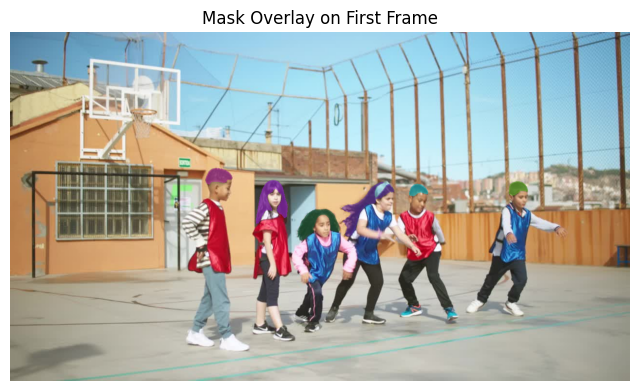

In [62]:
img0 = Image.open(image_path)

binary_masks = out['out_binary_masks']
np.random.seed(1000)
random_colors = np.random.rand(10, 3)
plt.figure(figsize=(8, 6))
plt.imshow(img0)
for m_idx, mask in enumerate(binary_masks):
    plot_mask(mask, color=random_colors[m_idx])
plt.axis('off')
plt.title("Mask Overlay on First Frame")
plt.show()